In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

import sklearn
print('Setup Complete')

Setup Complete


In [2]:
!pip install openpyxl

In [3]:
df = pd.read_excel('./data/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

Check for duplicates in the dataset and remove them from the data.

In [5]:
print('Duplicated entries: {}'.format(df.duplicated().sum()))
print('{}% rows are duplicate'.format(round((df.duplicated().sum()/df.shape[0])*100), 2))
df.drop_duplicates(inplace=True)

Duplicated entries: 5268
1% rows are duplicate


Check the total numnber of products, transactions and customers in the dataset

In [6]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),
              'transactions': len(df['InvoiceNo'].value_counts()),
              'customers': len(df['CustomerID'].value_counts()),
              }], columns=['products', 'transactions', 'customers'], index=['quantity'])

,products,transactions,customers
quantity,4070,25900,4372


Checking country wise distributions of transactions

In [7]:
temp = df.groupby(['Country'], as_index=False).agg({'InvoiceNo': 'nunique'}).rename(columns={'InvoiceNo': 'Orders'})
total = temp['Orders'].sum(axis=0)
temp['%Orders'] = round((temp['Orders']/total)*100, 4)

In [8]:
temp.sort_values(by=['%Orders'], ascending=False, inplace=True)
temp.reset_index(drop=True, inplace=True)

Text(0, 0.5, '%Orders')

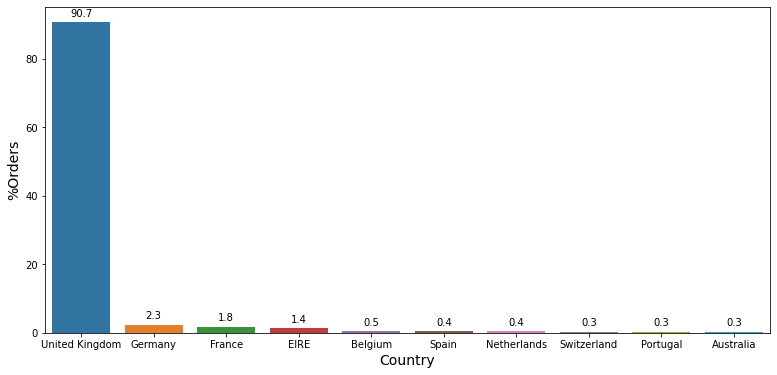

In [9]:
plt.figure(figsize=(13, 6))
splot = sns.barplot(x='Country', y='%Orders', data=temp[:10])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'center',
                  xytext = (0, 9),
                  textcoords = 'offset points')
plt.xlabel("Country", size=14)
plt.ylabel("%Orders", size=14)

We can see that 90% of the orders are coming in from the UK. For the purpose of this analysis we will only be looking at the data from the UK orders. The subset will be created in the next few steps.

Remove cancelled orders from the data.

In [10]:
invoices = df['InvoiceNo']

In [11]:
x = invoices.str.contains('C', regex=True)
x.fillna(0, inplace=True)
x = x.astype(int)
x.value_counts()

0    527390
1      9251
Name: InvoiceNo, dtype: int64

In [12]:
df['order_cancelled'] = x
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0


In [13]:
df['order_cancelled'].value_counts()

0    527390
1      9251
Name: order_cancelled, dtype: int64

In [14]:
n1 = df['order_cancelled'].value_counts()[1]
n2 = df.shape[0]
print('Number of orders cancelled: {}/{} ({:.2f}%)'.format(n1, n2, n1/n2*100))

Number of orders cancelled: 9251/536641 (1.72%)


In [15]:
df = df.loc[df['order_cancelled'] == 0, :]
df.reset_index(drop=True, inplace=True)

We can check the dataset again to see if we have any negative quantities where the order wasn't cancelled

In [16]:
df.loc[df['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_cancelled
2336,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom,0
4249,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom,0
7003,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
7004,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
7005,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
520928,581210,23395,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom,0
520930,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom,0
520931,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom,0
522503,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom,0


Notice how the `CustomerID` column has all NaN values with no unit price associated with it. We won't worry about what this means, we will just remove it from the dataset for now.

In [17]:
df = df[df['CustomerID'].notna()]

In [18]:
df.reset_index(drop=True, inplace=True)

In [19]:
# Now we will only use the orders that were from the UK since that accounts for 90% of our orders

df_uk = df[df['Country'] == 'United Kingdom']

In [20]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0


In [21]:
df_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349227 entries, 0 to 392716
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   InvoiceNo        349227 non-null  object        
 1   StockCode        349227 non-null  object        
 2   Description      349227 non-null  object        
 3   Quantity         349227 non-null  int64         
 4   InvoiceDate      349227 non-null  datetime64[ns]
 5   UnitPrice        349227 non-null  float64       
 6   CustomerID       349227 non-null  float64       
 7   Country          349227 non-null  object        
 8   order_cancelled  349227 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 26.6+ MB


Luckily we don't have any missing values anymore, and we only have the orders from the UK. Let's create a new dataframe to look at the amount of products that were purchased, the total transactions and the number of customers.

In [24]:
# pd.DataFrame([[{'products': len(df['StockCode'].value_counts()),
#                'transactions': len(df['InoiceNo'].value_counts()),
#                'customers': len(df['CustomerID'].value_counts()),
#                }], columns= ['products', 'transactions', 'customers'], index=['quantity']])

pd.DataFrame([{'products': len(df['StockCode'].value_counts()),
              'transactions': len(df['InvoiceNo'].value_counts()),
              'customers': len(df['CustomerID'].value_counts()),
              }], columns=['products', 'transactions', 'customers'], index=['quantity'])

,products,transactions,customers
quantity,3665,18536,4339


### Cohort Analysis

A cohort is a set of users who share similar characteristics over time. Cohort analysis groups the users into mutually exclusive groups and their behaviour is measured over time.

It can provide information about product and customer lifecycle.

There are three types of cohort analysis:

1. Time cohorts: It groups customers by their purchase behaviour over time.
2. Behaviour cohorts: It groups customers by the product or service they signed up for.
3. Size cohorts: Refers to various sizes of customers who purchase company's products or services. This categorization can be based on the amount of spending in some period of time.

Understanding the needs of various cohorts can help a company design custom-made services or products for particular segments.

In the following analysis, we will create Time cohorts and look at customers who remain active during particular cohorts over a period of time that they transact over.

In [25]:
# Reverting back to data without the `order_cancelled` column
cohort_data = df_uk[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']]

In [26]:
# Checking for any nulls in the data
cohort_data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [27]:
all_dates = (pd.to_datetime(cohort_data['InvoiceDate'])).apply(lambda x: x.date())

In [28]:
(all_dates.max() - all_dates.min()).days

373

In [29]:
# Start and end dates
print('Start date: {}'.format(all_dates.min()))
print('End date: {}'.format(all_dates.max()))

Start date: 2010-12-01
End date: 2011-12-09


In [30]:
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [31]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

cohort_data['InvoiceMonth'] = cohort_data['InvoiceDate'].apply(get_month)
grouping = cohort_data.groupby('CustomerID')['InvoiceMonth']
cohort_data['CohortMonth'] = grouping.transform('min')
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


In [32]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

invoice_year, invoice_month, _ = get_date_int(cohort_data, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(cohort_data, 'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
cohort_data['CohortIndex'] = years_diff * 12 + months_diff
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0


In [34]:
grouping = cohort_data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_counts

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,815.0,289.0,263.0,304.0,293.0,323.0,291.0,278.0,289.0,325.0,299.0,405.0,218.0
2011-01-01,358.0,76.0,93.0,84.0,119.0,99.0,90.0,87.0,108.0,117.0,127.0,43.0,NaN
2011-02-01,340.0,64.0,66.0,97.0,98.0,86.0,87.0,96.0,90.0,104.0,25.0,NaN,NaN
2011-03-01,419.0,64.0,109.0,83.0,94.0,69.0,111.0,96.0,119.0,38.0,NaN,NaN,NaN
2011-04-01,277.0,58.0,56.0,60.0,56.0,61.0,61.0,73.0,20.0,NaN,NaN,NaN,NaN
2011-05-01,256.0,48.0,44.0,44.0,53.0,58.0,68.0,23.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,214.0,38.0,31.0,51.0,51.0,69.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,169.0,30.0,33.0,39.0,47.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,141.0,32.0,32.0,34.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


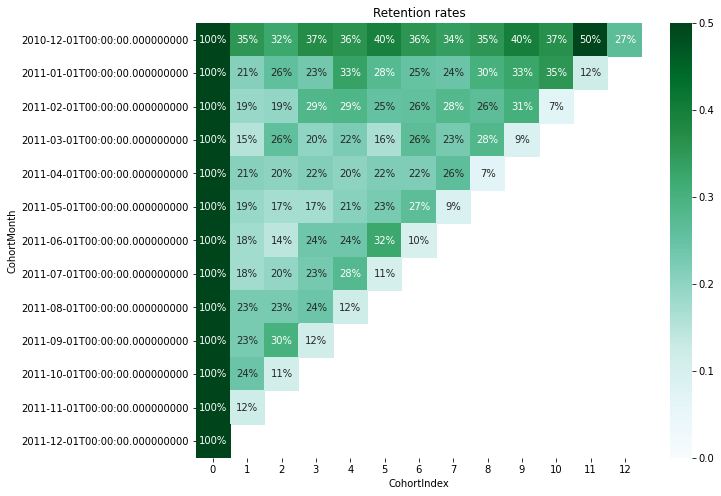

In [35]:
cohort_sizes = cohort_counts.iloc[:, 0]

retention = cohort_counts.divide(cohort_sizes, axis=0)

retention.round(3) * 100

plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap='BuGn')
plt.show();

### RFM Segmentation

RFM stands for recency, frequency, monetary. RFM analysis is a commonly used technique to generate and assign a score to each customer based on how recent theri last transaction was (Recency), how many transations they have made in the last year (Frequency), and what the monetary value of their transactions are (Monetary).